<a href="https://colab.research.google.com/github/EmoreiraV/DPIP/blob/main/ML_week11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Machine Learning in Python

This week we will be using the Python library Scikit-Learn, better known as Sklearn. I personally thinkn Sklearn is a lot easier to use for modelling than any of the models from the statistical packages last week. The reasons for this are:

- all methods have the same interface
- lots of built in data organisation methods (test-train split etc)
- lots of built in evaluation methods

The notes seem to mainly focus on classification, so I will be looking at traditional regression with a continuous outcome

In [ ]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

# Cubic Polynomial Data

Once again I am going to focus on the cubic regression model that I have looked at over the last few weeks. Here is how I generated it as a reminder

In [ ]:
beta = [1,-1,-0.1,0.1]
x = np.linspace(-5, 5, 50)
y_true = beta[0] * 1 + beta[1] * x + beta[2] * x**2 + beta[3] * x**3
y = y_true + np.random.normal(0,1,50)

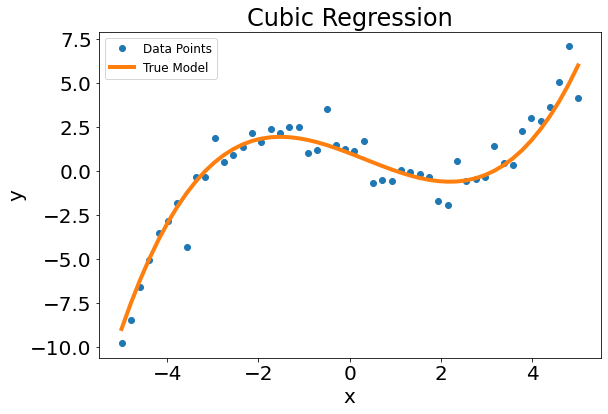

In [ ]:
# Figure size
plt.figure(figsize=[9,6])
# font size
plt.rcParams.update({'font.size': 20})
plt.rc('legend', fontsize=12)
# plot the data
line_width = 4
plt.plot(x, y, 'o', label='Data Points')
plt.plot(x, y_true, linewidth=line_width, label='True Model')
# add axes titles
plt.xlabel('x')
plt.ylabel('y')
plt.title('Cubic Regression')
# add legend
plt.legend()
# show plot
plt.show()

Let's start by creating some base variables that we can work with. I'm going to create a lot of variables to give us some different models to try


In [ ]:
from sklearn.preprocessing import PolynomialFeatures
poly_reg = PolynomialFeatures(degree=9)
X = poly_reg.fit_transform(x.reshape((50,1)))

## Data Normalisation
Let's do some data normalisation to make it a little easier to handle, but lets see why we need to do it first

In [ ]:
print(X.mean(axis=0))
print(X.std(axis=0))

[ 1.00000000e+00 -7.10542736e-17  8.67346939e+00  2.55795385e-15
  1.35340079e+02  6.36646291e-14  2.51274802e+03  1.74622983e-12
  5.07718969e+04  6.05359674e-11]
[0.00000000e+00 2.94507545e+00 7.75312893e+00 5.01273181e+01
 1.80152601e+02 1.03855715e+03 4.16782197e+03 2.30739884e+04
 9.79819097e+04 5.31341848e+05]


Now lets standardise

In [ ]:
from sklearn.preprocessing import StandardScaler
stand = StandardScaler()
X_transformed = stand.fit_transform(X)

and here is what we see now

In [ ]:
print(X_transformed.mean(axis=0))
print(X_transformed.std(axis=0))

[ 0.00000000e+00  5.77315973e-17 -1.77635684e-16  4.44089210e-17
  2.66453526e-16  1.15463195e-16 -7.10542736e-17 -4.44089210e-17
  1.50990331e-16  4.44089210e-17]
[0. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


## Test-Train Split
Let's split the data into test and train so that we can check how well we do at fitting our models

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_transformed, y, test_size=0.20)

## Linear Regression
Lets start with some basic linear regression

**An Aside: Is Linear Regression a Machine Learning method or a Statistics method?**

There is no definition of what defines a machine learning model as opposed to a statistics model (or even an AI model). You could go by where they are mainly used or where they were invented, but in my books its better to just use the phrases a bit interchangably. Why can a model not be both? If I had to choose then I would pick based on where they are used most. So Statistics models being linear regression, k-means; Machine Learning being Gaussian Processes, Neural Nets and SVM; and the LASSO being both. Technically both LASSO and Gaussian Process were invent in Statistics long before their adoption in Machine Learning. At the end of the day, all Machine Learning and AI is based on basic, core statistical methods and principles. **Anyways...**

Lets fit some regression models. I'm going to fit all the models from the intercept model up to the 8th polynomial model and analyse a few different things to show the great add ons in Sklearn

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
in_sample_errors = []
out_sample_errors = []

Lets now loop over all the other models and fit them

In [ ]:
for i in range(10):
  model = LinearRegression(fit_intercept=False)
  model.fit(X_train[:,:(i+1)], y_train)
  y_predict_in_sample = model.predict(X_train[:,:(i+1)])
  y_predict_out_sample = model.predict(X_test[:,:(i+1)])
  in_sample_errors.append(mean_squared_error(y_predict_in_sample, y_train))
  out_sample_errors.append(mean_squared_error(y_predict_out_sample, y_test))

Now lets plot the result and see what happens with the different errors

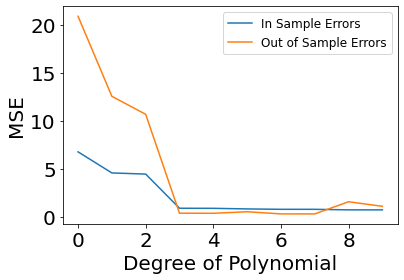

In [ ]:
plt.plot(range(10), in_sample_errors,label='In Sample Errors')
plt.plot(range(10), out_sample_errors,label='Out of Sample Errors')
plt.xlabel('Degree of Polynomial')
plt.ylabel('MSE')
plt.legend()
plt.show()

In kind of looks like the errors stay the same when the polynomial gets to degree 3. Let's have a closer look

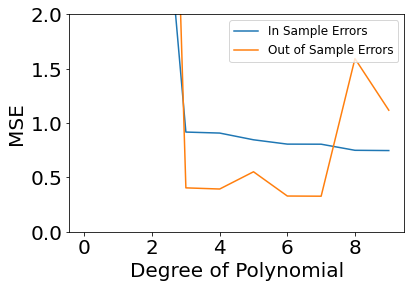

In [ ]:
plt.plot(range(10), in_sample_errors,label='In Sample Errors')
plt.plot(range(10), out_sample_errors,label='Out of Sample Errors')
plt.xlabel('Degree of Polynomial')
plt.ylabel('MSE')
plt.ylim((0,2))
plt.legend()
plt.show()

In the example where I ran the simulations it looks like the 3rd Polynomial might be the best in terms of out-of-sample error (yours may be different, sorry I forgot to use a seed). Why does the in-sample-error keep going down, but the out-of-sample starts to go up?

In [ ]:
print(np.array(in_sample_errors).argmin())
print(np.array(in_sample_errors).min())
print(np.array(out_sample_errors).argmin())
print(np.array(out_sample_errors).min())

9
0.7472814172790321
7
0.32743434485185813


## LASSO

Let's do some variable selection with the LASSO, using CV to choose the best lambda parameter

In [ ]:
from sklearn.linear_model import LassoCV
reg = LassoCV(cv=5,tol=0.01).fit(X_train, y_train)
lasso_predict_in_sample = reg.predict(X_train)
lasso_predict_out_sample = reg.predict(X_test)
print(mean_squared_error(lasso_predict_in_sample, y_train))
print(mean_squared_error(lasso_predict_out_sample, y_test))
print(reg.coef_)

0.7952949195410352
0.7080649062442939
[ 0.         -3.32752745 -0.70063556  5.75642595  0.0696812   0.58569235
  0.          0.         -0.05361895 -0.99609736]


Let's plot the results so we can see how we are doing

In [ ]:
predict_lasso = reg.predict(X_transformed)

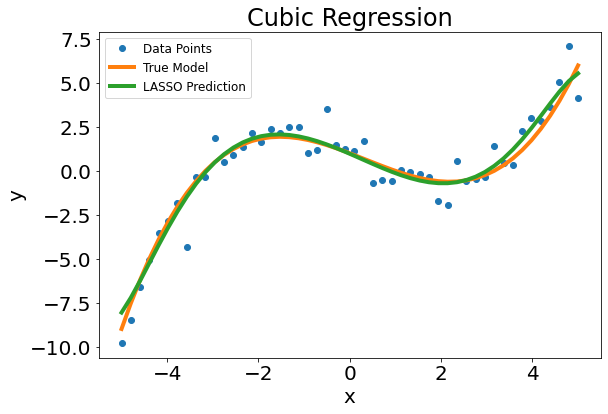

In [ ]:
# Figure size
plt.figure(figsize=[9,6])
# font size
plt.rcParams.update({'font.size': 20})
plt.rc('legend', fontsize=12)
# plot the data
line_width = 4
plt.plot(x, y, 'o', label='Data Points')
plt.plot(x, y_true, linewidth=line_width, label='True Model')
plt.plot(x, predict_lasso, linewidth=line_width, label='LASSO Prediction')
# add axes titles
plt.xlabel('x')
plt.ylabel('y')
plt.title('Cubic Regression')
# add legend
plt.legend()
# show plot
plt.show()

## Gaussian Process

Let's fit a GP using Sklearn rather than a GAM in R like last week

In [ ]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel
kernel = 1.0 * RBF(1.0) + WhiteKernel()
gp = GaussianProcessRegressor(kernel=kernel,random_state=0).fit(X_train, y_train)
gp_predict_in_sample = reg.predict(X_train)
gp_predict_out_sample = reg.predict(X_test)
print(mean_squared_error(gp_predict_in_sample, y_train))
print(mean_squared_error(gp_predict_out_sample, y_test))

0.7952949195410352
0.7080649062442939


Let's plot the results

In [ ]:
predict_gp = gp.predict(X_transformed,return_std=True)

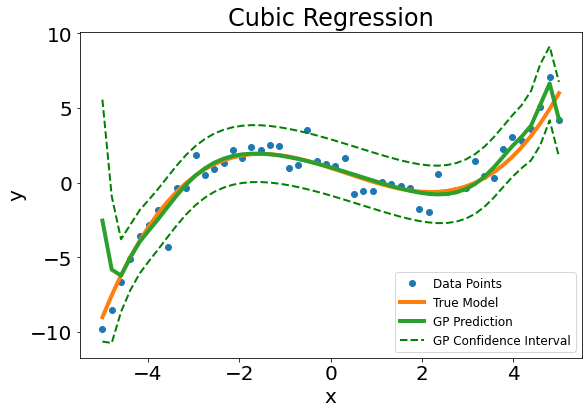

In [ ]:
# Figure size
plt.figure(figsize=[9,6])
# font size
plt.rcParams.update({'font.size': 20})
plt.rc('legend', fontsize=12)
# plot the data
line_width = 4
plt.plot(x, y, 'o', label='Data Points')
plt.plot(x, y_true, linewidth=line_width, label='True Model')
plt.plot(x, predict_gp[0], linewidth=line_width, label='GP Prediction')
plt.plot(x, predict_gp[0] + 1.96 * predict_gp[1], '--', linewidth=2, color='g', label='GP Confidence Interval')
plt.plot(x, predict_gp[0] - 1.96 * predict_gp[1], '--', linewidth=2, color='g')
# add axes titles
plt.xlabel('x')
plt.ylabel('y')
plt.title('Cubic Regression')
# add legend
plt.legend()
# show plot
plt.show()

## Random Forest Regression

and lets do some Random Forest regression as they are always popular

In [ ]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(max_depth=3, random_state=0)
rf.fit(X_train, y_train)
rf_predict_in_sample = rf.predict(X_train)
rf_predict_out_sample = rf.predict(X_test)
print(mean_squared_error(rf_predict_in_sample, y_train))
print(mean_squared_error(rf_predict_out_sample, y_test))

0.6624513119437445
3.4605227780827823


Let's plot the results

In [ ]:
predict_rf = rf.predict(X_transformed)

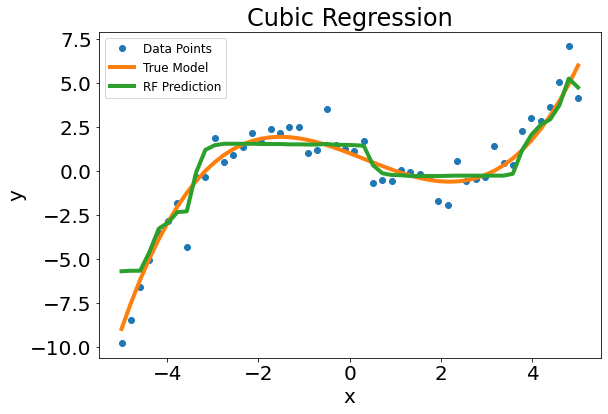

In [ ]:
# Figure size
plt.figure(figsize=[9,6])
# font size
plt.rcParams.update({'font.size': 20})
plt.rc('legend', fontsize=12)
# plot the data
line_width = 4
plt.plot(x, y, 'o', label='Data Points')
plt.plot(x, y_true, linewidth=line_width, label='True Model')
plt.plot(x, predict_rf, linewidth=line_width, label='RF Prediction')
# add axes titles
plt.xlabel('x')
plt.ylabel('y')
plt.title('Cubic Regression')
# add legend
plt.legend()
# show plot
plt.show()